# Tutorial: Classifying hands poses with Kendall shape spaces

In this tutorial, we show how to use geomstats to perform a shape data analysis. Specifically, we aim to study the difference between two groups of data:
- hand poses that correspond to the action "Grab",
- hand poses heads that correspond to the action "Expand".

We wish to investigate if there is a difference in these two groups.


The hand poses are represented as the coordinates of 22 joints in 3D:

<img src="figures/hand_skeleton.png" width=300 height=300/>

## Setup

In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import geomstats.visualization as visualization
import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

visualization.tutorial_matplotlib()

INFO: Using numpy backend


### Hands shapes

Load the dataset of hand poses, where a hand is represented as a 
set of 22 landmarks - the hands joints - in 3D.

The hand poses represent two different hand poses:
- Label 0: hand is in the position "Grab"
- Label 1: hand is in the position "Expand"

This is a subset of the SHREC 2017 dataset (SWVGLF2017).

##### Reference
(SWVGLF2017) Q. De Smedt, H. Wannous, J.P. Vandeborre, 
J. Guerry, B. Le Saux, D. Filliat, SHREC'17 Track: 3D Hand Gesture 
Recognition Using a Depth and Skeletal Dataset, 10th Eurographics 
Workshop on 3D Object Retrieval, 2017.
https://doi.org/10.2312/3dor.20171049


We load the dataset of landmarks' sets and corresponding labels.

In [3]:
hands, labels, bone_list = data_utils.load_hands()

In [4]:
print(hands.shape)
print(labels)

(52, 22, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


We extract two hands, one corresponding to the "Grab" pose, and the other to the "Expand" pose.

In [5]:
label_to_str = {0: 'Grab', 1: 'Expand'}
label_to_color = {0: (102/255, 178/255, 255/255, 1.), 1: (255/255, 178/255, 102/255, 1.)}
first_grab_hand = hands[labels==0][0]
first_expand_hand = hands[labels==1][0]

We implement a function to plot one hand in 3D.

In [6]:
def plot_hand(hand, bone_list):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    x = hand[:, 0]
    y = hand[:, 1]
    z = hand[:, 2]

    sc = ax.scatter(x, y, z, s=40)
    for bone in bone_list:
        start_bone_idx = bone[0]
        end_bone_idx = bone[1]
        ax.plot(
            xs=[x[start_bone_idx], x[end_bone_idx]],
            ys=[y[start_bone_idx], y[end_bone_idx]],
            zs=[z[start_bone_idx], z[end_bone_idx]],
        )

We plot two examples of hands.

<IPython.core.display.Javascript object>


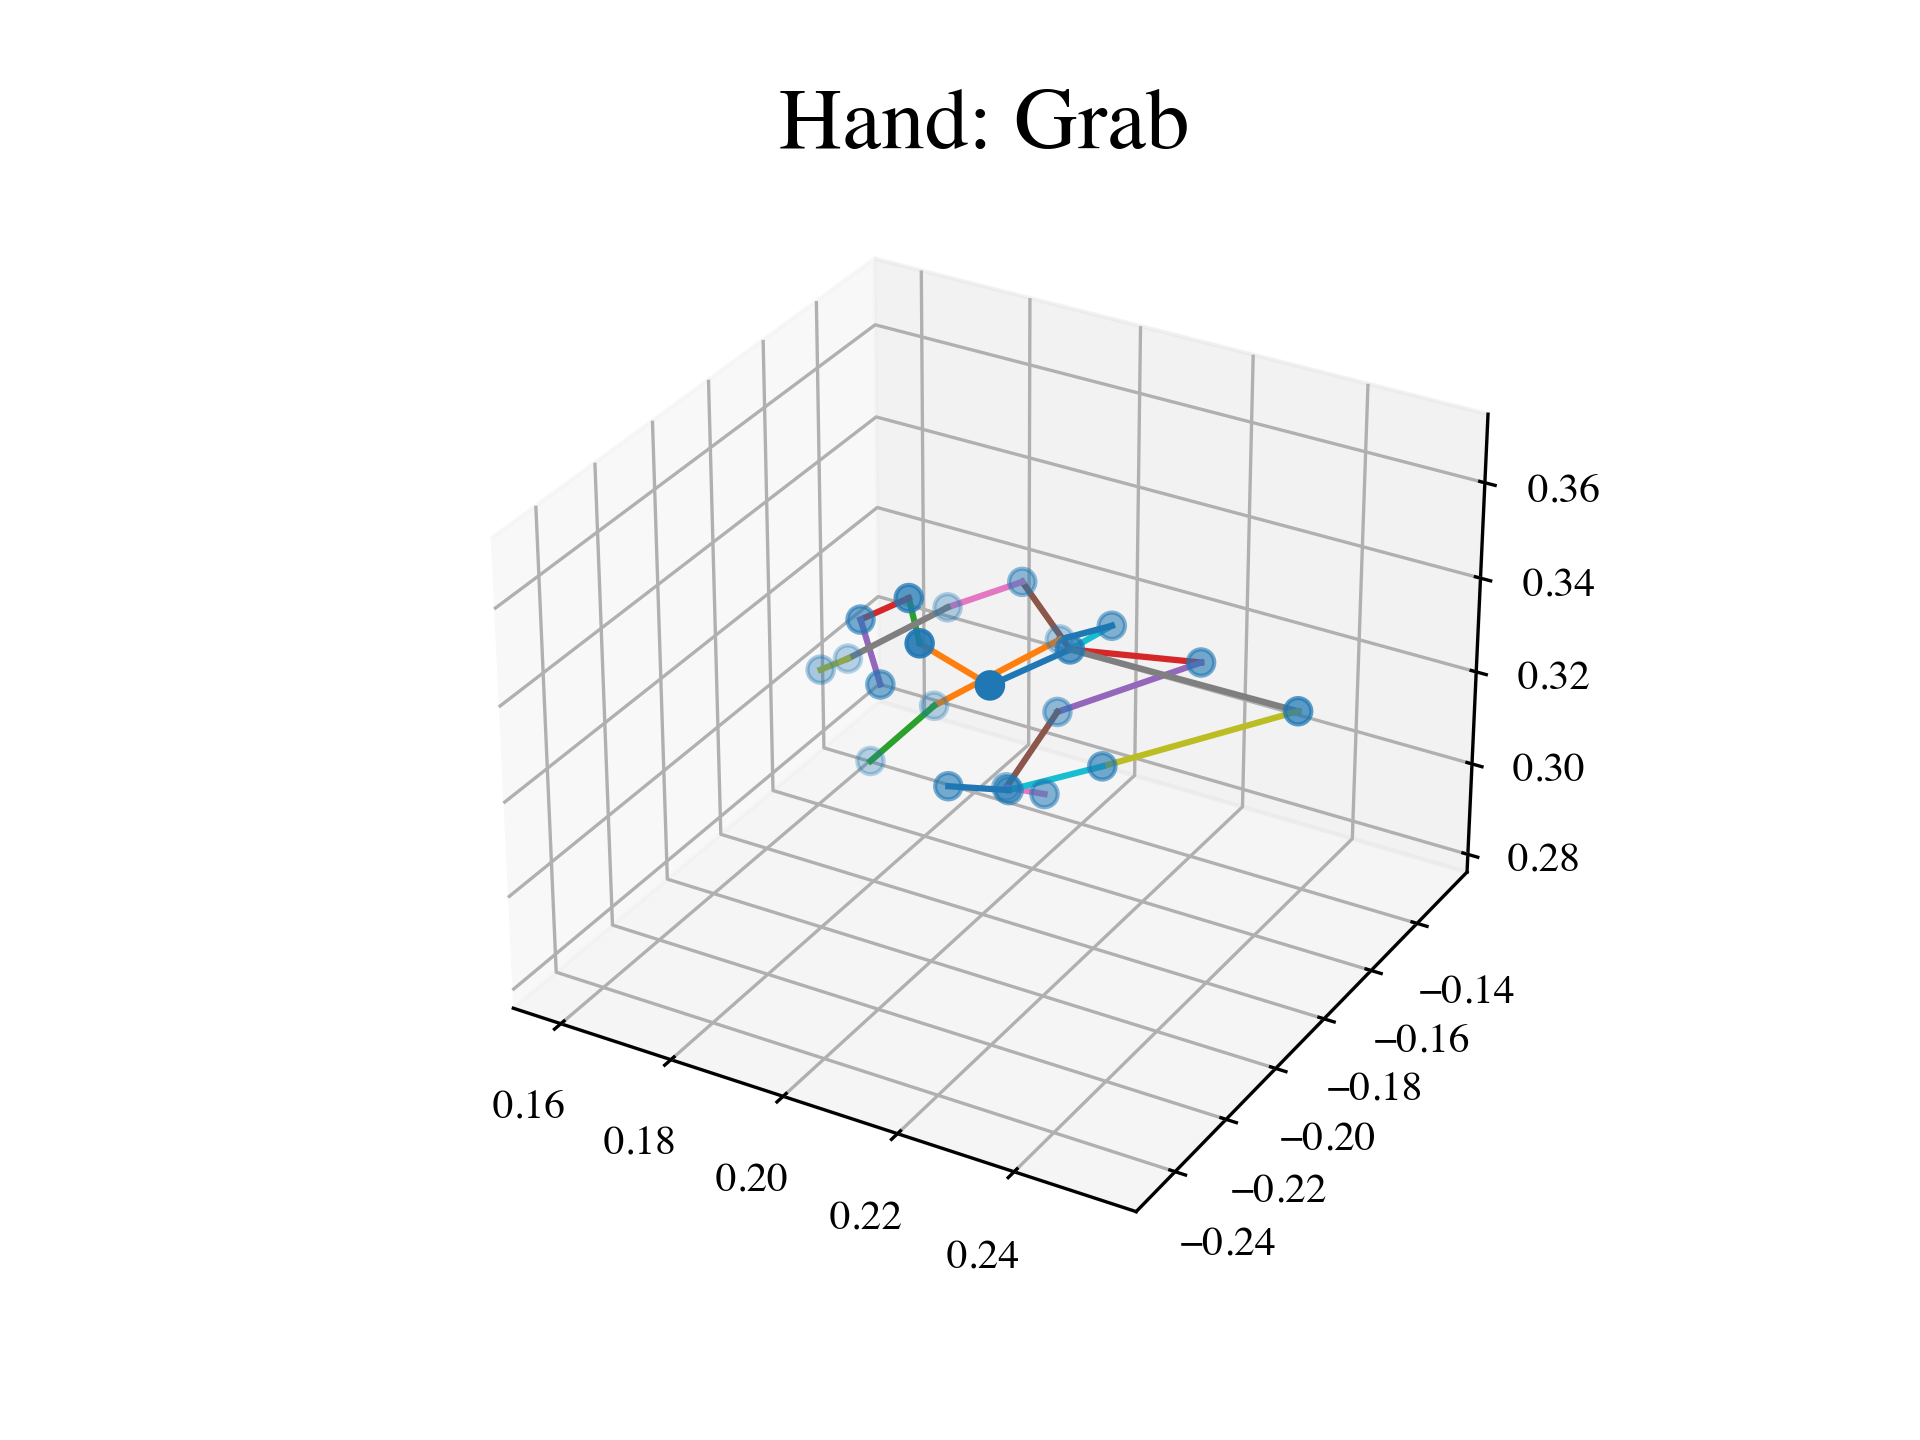

Text(0.5, 0.92, 'Hand: Grab')

In [7]:
%matplotlib notebook

plot_hand(first_grab_hand, bone_list)
plt.title(f"Hand: {label_to_str[0]}")

<IPython.core.display.Javascript object>


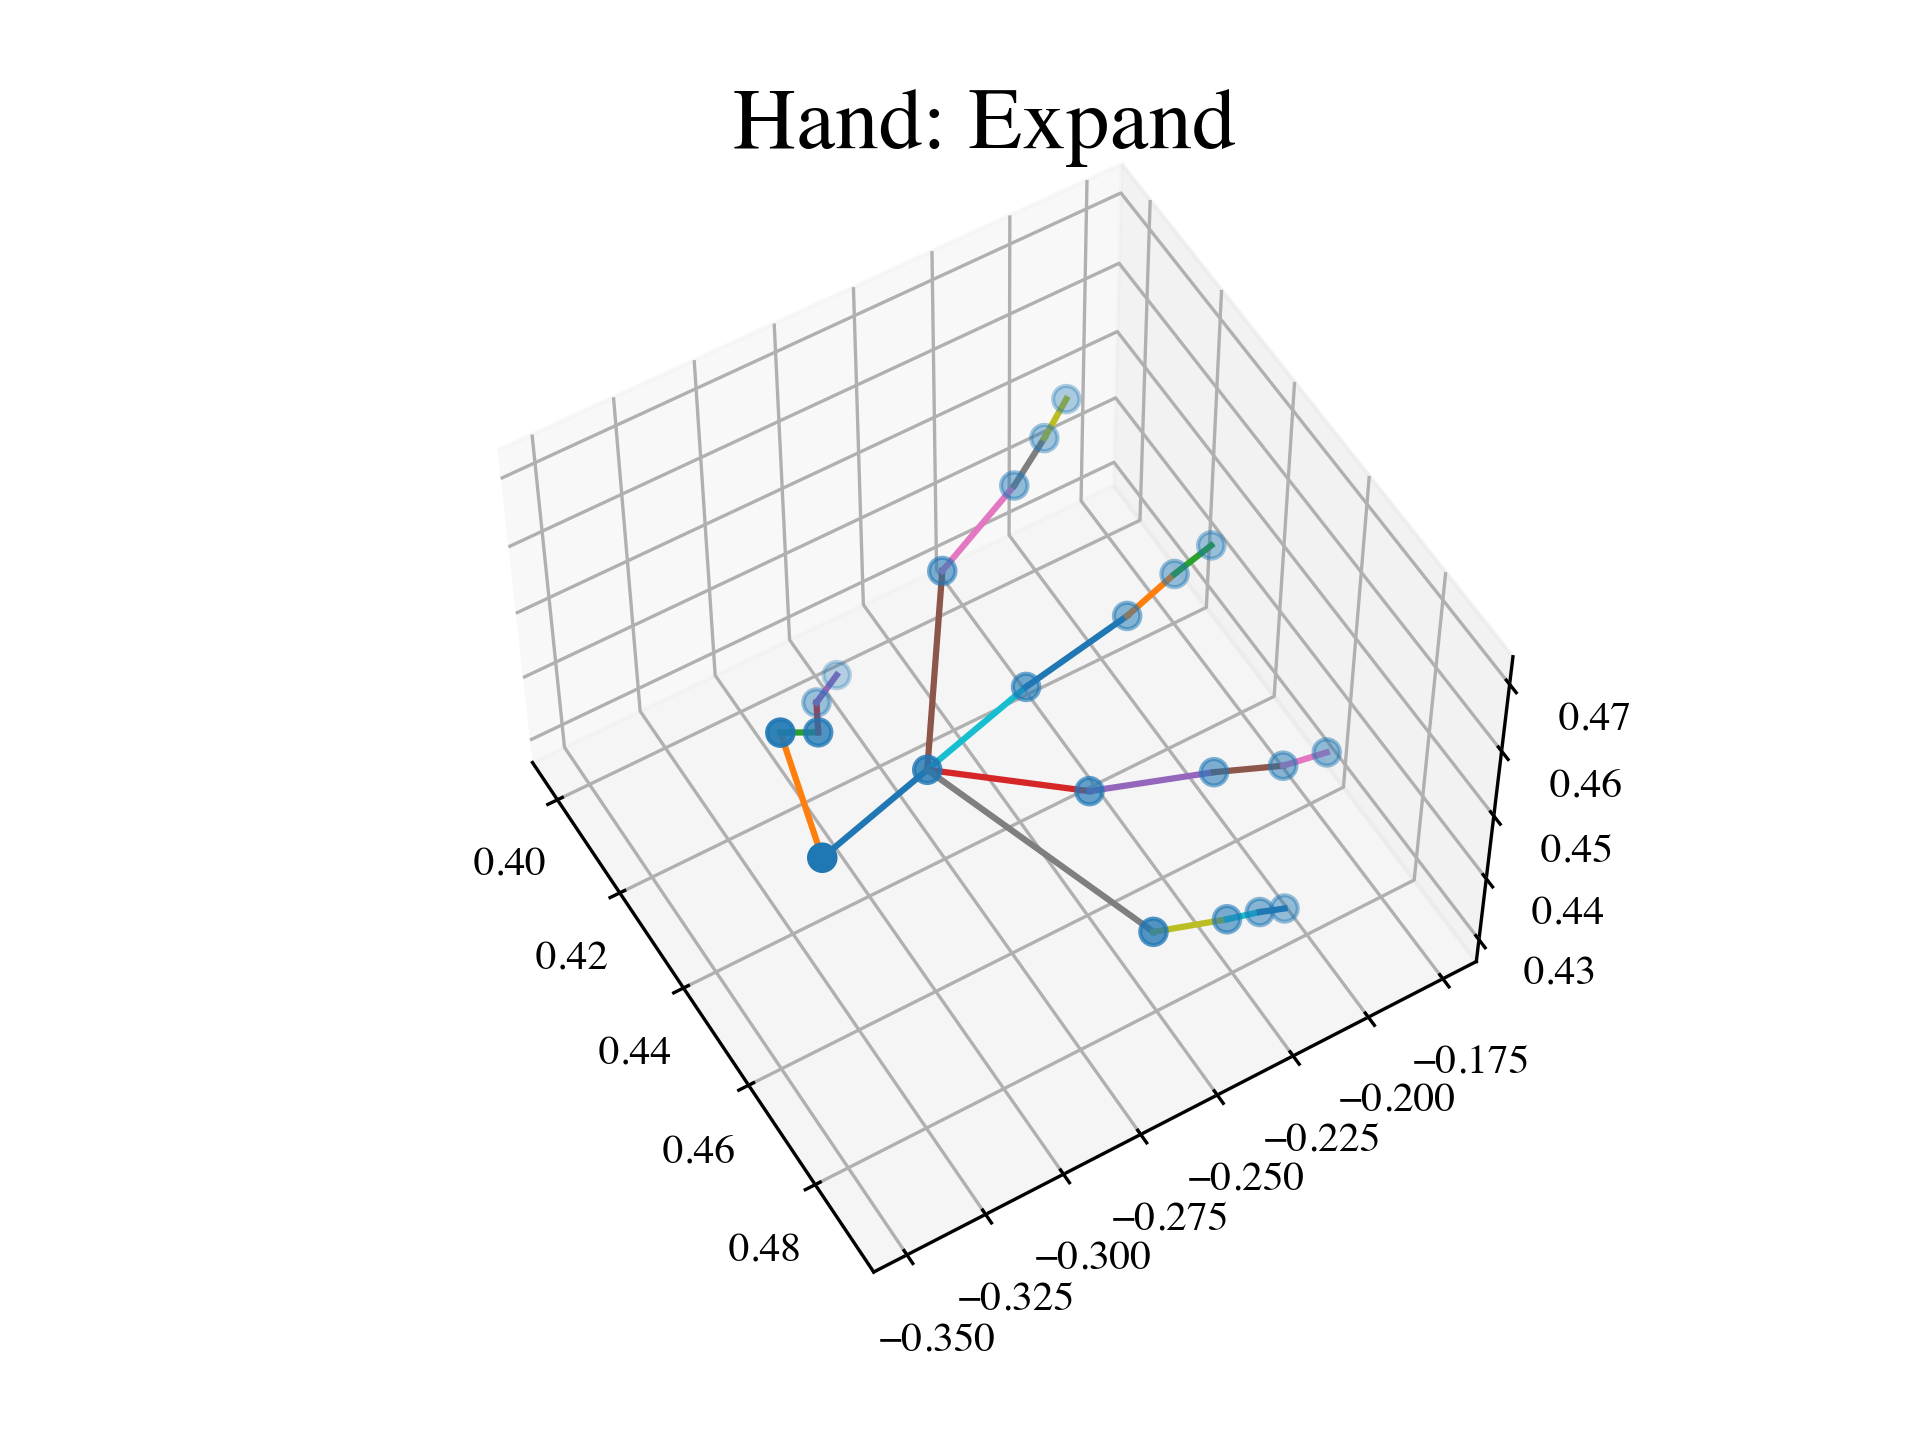

In [8]:
plot_hand(first_expand_hand, bone_list)
plt.title(f"Hand: {label_to_str[1]}");

We want to investigate if there is a difference between these two groups of shapes - grab versus expand - or if the main difference is merely relative to the global size of the landmarks' sets.

<IPython.core.display.Javascript object>


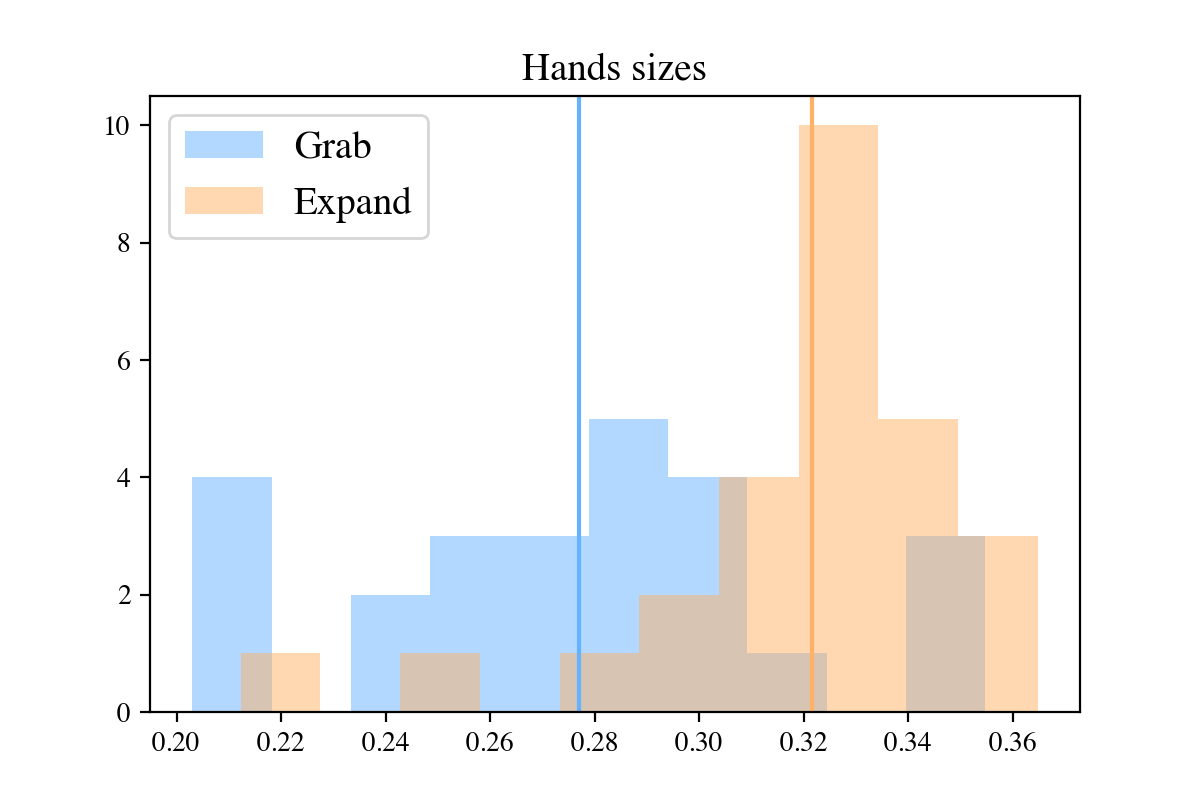

In [12]:
m_ambient = 3
k_landmarks = 22

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric

sizes = matrices_metric.norm(preshape.center(hands))

plt.figure(figsize=(6, 4))
for label, col in label_to_color.items():
    label_sizes = sizes[labels==label]
    plt.hist(label_sizes, color=col, label=label_to_str[label], alpha=0.5, bins=10)
    plt.axvline(gs.mean(label_sizes),  color=col)
plt.legend(fontsize=14)
plt.title('Hands sizes', fontsize=14);

We perform a hypothesis test, testing if the two samples of sizes have the same average.

In [13]:
from scipy import stats

signif_level = 0.05

tstat, pvalue = stats.ttest_ind(sizes[labels==0], sizes[labels==1])
print(pvalue < signif_level)

True


The size could be a characteristic allowing to distinguish between these two specific shapes.

We want to investigate if there is a difference in shapes, where the size component has been quotiented out. 

We project the data to the Kendall pre-shape space, which:
- centers the hand landmark sets so that they share the same barycenter,
- normalizes the sizes of the landmarks' sets to 1.

Directly looking at the hands by looking at the coordinates of their landmarks in 3D does not show clear clusters

<IPython.core.display.Javascript object>


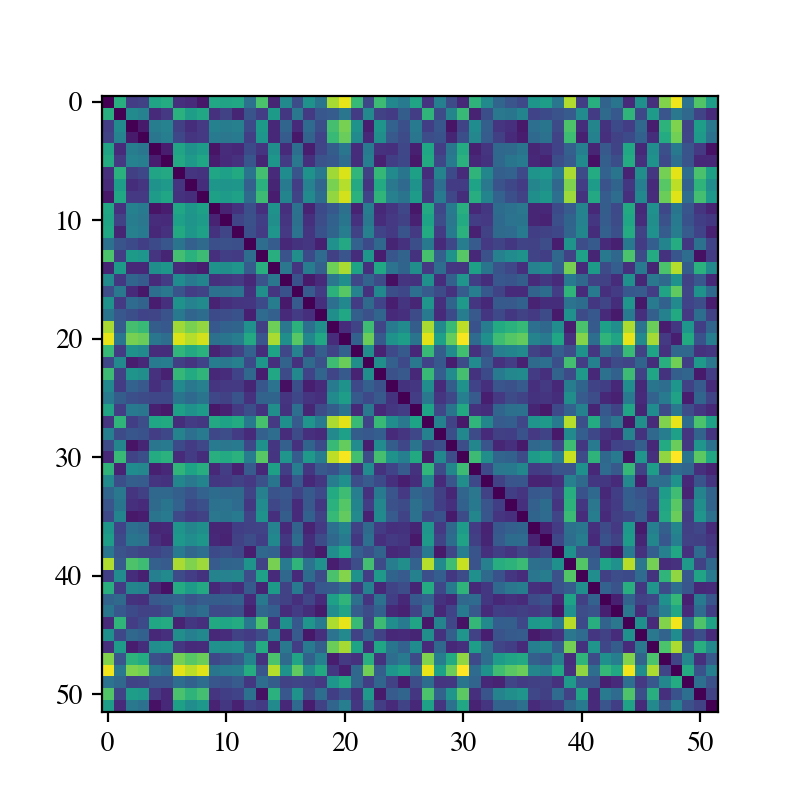

In [14]:
from geomstats.geometry.euclidean import EuclideanMetric

eucl_metric = EuclideanMetric(3*22)
hands_vec = hands.reshape(52, -1)
eucl_pair_dist = eucl_metric.dist_pairwise(hands_vec)


plt.figure(figsize=(4, 4))
plt.imshow(eucl_pair_dist);

We project the hands in a Kendall shape space.

In [15]:
hands_preshape = preshape.projection(hands)
print(hands_preshape.shape)
print(preshape.belongs(hands_preshape))
print(gs.isclose(matrices_metric.norm(hands_preshape), 1.))

(52, 22, 3)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In order to quotient out the 3D orientation component, we align the landmark sets in the preshape space. 

In [16]:
base_point = hands_preshape[0]

hands_shape = preshape.align(point=hands_preshape, base_point=base_point)
print(hands_shape.shape)

(52, 22, 3)


The Kendall metric is a Riemannian metric that takes this alignment into account. It corresponds to the metric of the Kendall shape space, which is the manifold defined as the preshape space quotient by the action of the rotation in m_ambient dimensions, here in 3 dimensions.

In [17]:
kendall_metric = KendallShapeMetric(m_ambient=m_ambient, k_landmarks=k_landmarks)

We can use it to perform a tangent PCA in the Kendall shape space, and determine if we see a difference in the hand shapes.

<IPython.core.display.Javascript object>


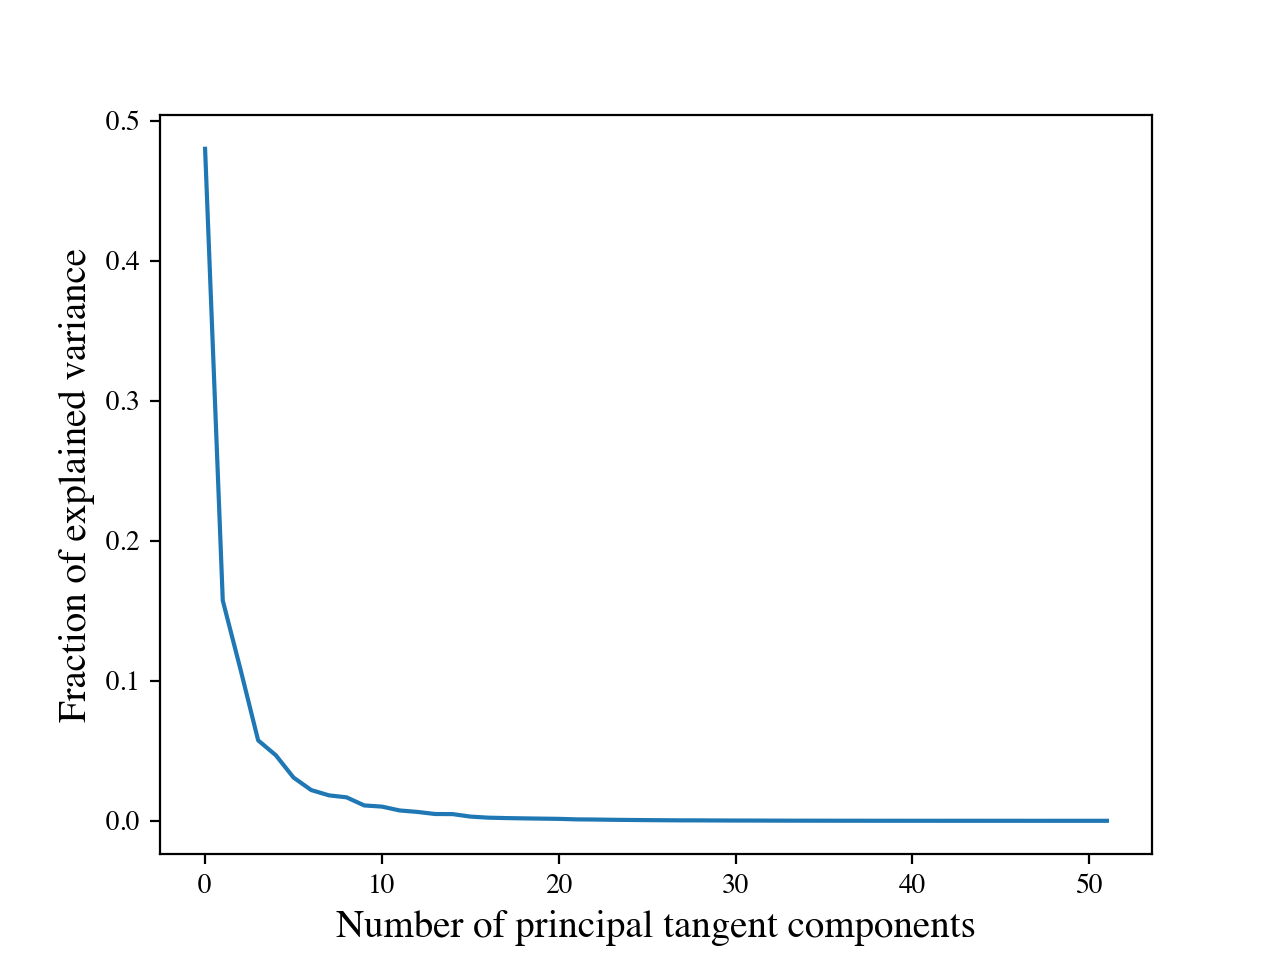

In [18]:
from geomstats.learning.pca import TangentPCA

tpca = TangentPCA(kendall_metric)
tpca.fit(hands_shape)

plt.figure()
plt.plot(
    tpca.explained_variance_ratio_)
plt.xlabel("Number of principal tangent components", size=14)
plt.ylabel("Fraction of explained variance", size=14);

The first 2 principal components capture around 60% of the variance.

<IPython.core.display.Javascript object>


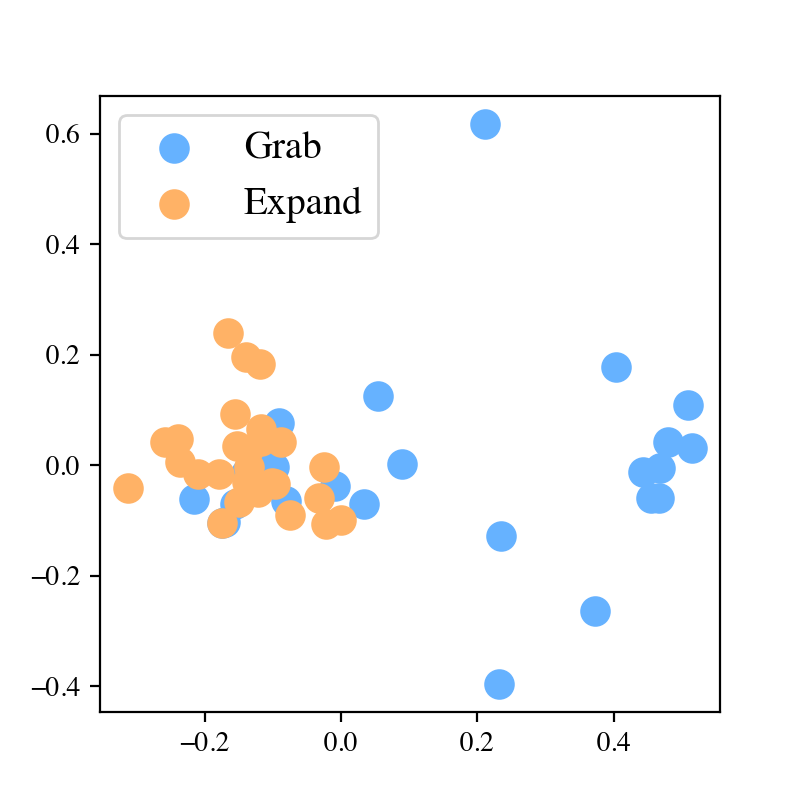

In [19]:
X = tpca.transform(hands_shape)

plt.figure(figsize=(4, 4))

for label, col in label_to_color.items():
    mask = labels == label
    plt.scatter(X[mask, 0], X[mask, 1], color=col, s=100, label=label_to_str[label]);
plt.legend(fontsize=14);

In [20]:
dist_pairwise = kendall_metric.dist_pairwise(hands_shape)
print(dist_pairwise.shape)

(52, 52)


<IPython.core.display.Javascript object>


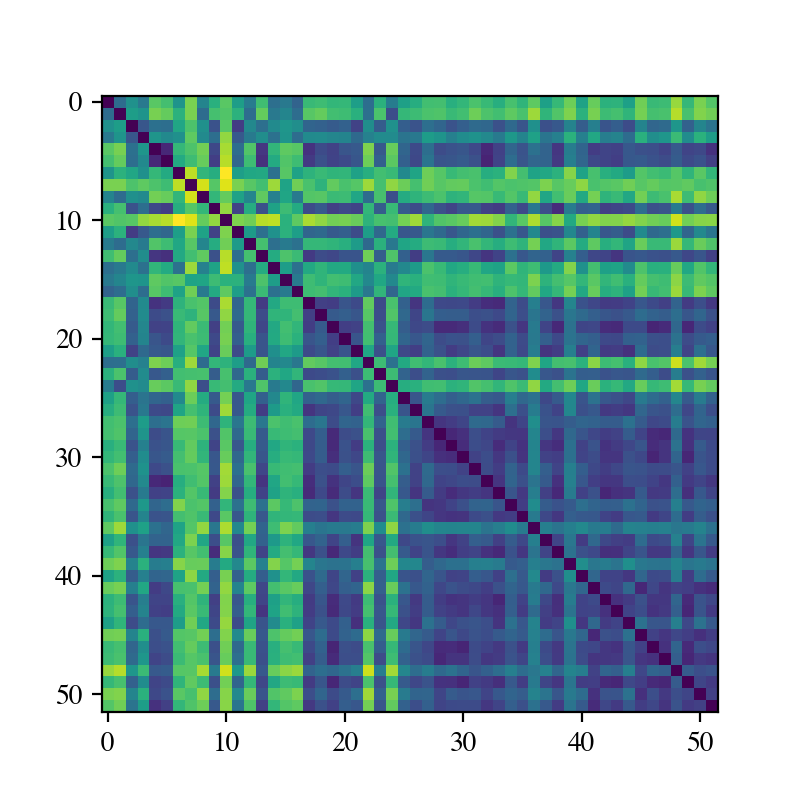

In [21]:
plt.figure(figsize=(4, 4))
plt.imshow(dist_pairwise);

This distance matrix can now be used to perform clustering on the hands shapes.